# About EfficientNet

**EfficientNet** is a lightweight convolutional neural network architecture achieving the state-of-the-art accuracy with an order of magnitude fewer parameters and FLOPS, on both ImageNet and five other commonly used transfer learning datasets.

**EfficientNets** rely on AutoML and compound scaling to achieve superior performance without compromising resource efficiency. The AutoML Mobile framework has helped develop a mobile-size baseline network, EfficientNet-B0, which is then improved by the compound scaling method to obtain EfficientNet-B1 to B7.

<img src='https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/flops.png' width="500" height="600">

EfficientNets achieve state-of-the-art accuracy on ImageNet with an order of magnitude better efficiency:

* In high-accuracy regime, EfficientNet-B7 achieves the state-of-the-art 84.4% top-1 / 97.1% top-5 accuracy on ImageNet with 66M parameters and 37B FLOPS. At the same time, the model is 8.4x smaller and 6.1x faster on CPU inference than the former leader, Gpipe.

* In middle-accuracy regime, EfficientNet-B1 is 7.6x smaller and 5.7x faster on CPU inference than ResNet-152, with similar ImageNet accuracy.

* Compared to the widely used ResNet-50, EfficientNet-B4 improves the top-1 accuracy from 76.3% of ResNet-50 to 82.6% (+6.3%), under similar FLOPS constraints.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import cv2
from IPython.display import Image

In [2]:
def show(img):
    return (Image(cv2.imencode(".png",img)[1].tobytes()))

# Read Data

In [3]:
base_path = '/kaggle/input/intel-image-classification/'
folders = os.listdir(base_path)
print(folders)

['seg_train', 'seg_pred', 'seg_test']


In [4]:
base_path+folders[0]+'/'

'/kaggle/input/intel-image-classification/seg_train/'

# EDA

In [5]:
train_folders = os.listdir(os.path.join(base_path,folders[0],folders[0]))
print(f'train_folders: {train_folders}')
print('----Train Data Distribution-----')
print(f'Folder Name : No. of Images')
for folder in train_folders:
    print(f'{folder:11} : {len(os.listdir(os.path.join(base_path,folders[0],folders[0],folder)))}')

train_folders: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
----Train Data Distribution-----
Folder Name : No. of Images
mountain    : 2512
street      : 2382
buildings   : 2191
sea         : 2274
forest      : 2271
glacier     : 2404


In [6]:
val_folders = os.listdir(os.path.join(base_path,folders[2],folders[2]))
print(f'val_folders: {val_folders}')
print('----Val Data Distribution-----')
print(f'Folder Name : No. of Images')
for folder in val_folders:
    print(f'{folder:11} : {len(os.listdir(os.path.join(base_path,folders[2],folders[2],folder)))}')

val_folders: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
----Val Data Distribution-----
Folder Name : No. of Images
mountain    : 525
street      : 501
buildings   : 437
sea         : 510
forest      : 474
glacier     : 553


In [7]:
test_images = os.listdir(os.path.join(base_path,folders[1],folders[1]))
print(f'test_images: {len(test_images)}')
print('First ten Images')
print(test_images[:10])

test_images: 7301
First ten Images
['6234.jpg', '22288.jpg', '20529.jpg', '21440.jpg', '5982.jpg', '7737.jpg', '2081.jpg', '10054.jpg', '3919.jpg', '21838.jpg']


# Import Libraries

In [8]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 2.5 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
# from keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications import EfficientNetB2
import efficientnet.keras as efn 
# model = efn.EfficientNetB0(weights='imagenet') 
from keras import Model, layers
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input

print("Libraries Imported!")

Libraries Imported!


In [10]:
train_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train/"

train_datagen = ImageDataGenerator( rescale = 1.0/255,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          zoom_range=0.2,
                                          vertical_flip=True,
                                          fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(train_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(250, 250))

test_DIR = "/kaggle/input/intel-image-classification/seg_test/seg_test/"
validation_datagen = ImageDataGenerator(rescale = 1.0/255)


validation_generator = validation_datagen.flow_from_directory(test_DIR,
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    target_size=(250, 250))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [11]:
print(validation_generator.class_indices)
class2index = validation_generator.class_indices

index2class = {v: k for k, v in class2index.items()}
print(index2class)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


# Get Model

In [12]:
efficientNet = efn.EfficientNetB1(weights='imagenet')

# for layer in efficientNet.layers:
#     layer.trainable = False

32145408/32139920 [==============================] - 0s 0us/step


In [13]:

last_output = efficientNet.layers[-1].output

In [14]:
# x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(units = 128, activation = tf.nn.relu)(last_output)
# x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense  (6, activation = tf.nn.softmax)(x)

model = tf.keras.Model( efficientNet.input, x)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=1,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.000003)

model.compile(loss = 'categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(), metrics=['acc'])

# model.summary()

# Train

In [15]:
history = model.fit(train_generator,
                    epochs = 15,
                    verbose = 1,
                   validation_data = validation_generator,
                   callbacks=[learning_rate_reduction])

Epoch 1/15
439/439 [==============================] - 362s 825ms/step - loss: 1.0657 - acc: 0.6300 - val_loss: 0.8291 - val_acc: 0.6923
Epoch 2/15
439/439 [==============================] - 295s 672ms/step - loss: 0.6914 - acc: 0.7456 - val_loss: 0.7788 - val_acc: 0.7163
Epoch 3/15
439/439 [==============================] - 308s 702ms/step - loss: 0.5254 - acc: 0.8169 - val_loss: 0.5974 - val_acc: 0.8087
Epoch 4/15
439/439 [==============================] - 331s 755ms/step - loss: 0.4628 - acc: 0.8403 - val_loss: 0.4148 - val_acc: 0.8677
Epoch 5/15
439/439 [==============================] - ETA: 0s - loss: 0.4362 - acc: 0.8449
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
439/439 [==============================] - 342s 779ms/step - loss: 0.4362 - acc: 0.8449 - val_loss: 0.6488 - val_acc: 0.7820
Epoch 6/15
439/439 [==============================] - 339s 772ms/step - loss: 0.3878 - acc: 0.8627 - val_loss: 0.3081 - val_acc: 0.8880
Epoch 7/15
439/439 [====

# Visualize Model Perfomance

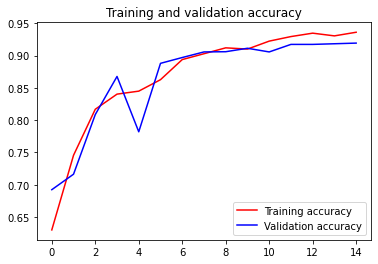

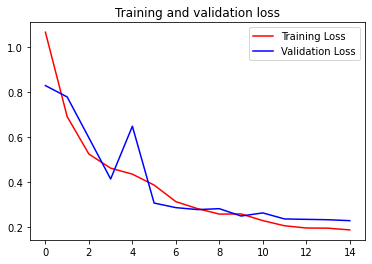

In [16]:
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
print(validation_generator.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [18]:
path = os.path.join(base_path,folders[1],folders[1],test_images[0])
img = cv2.resize(cv2.imread(path),(250,250))
img.shape


(250, 250, 3)

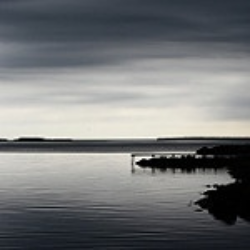

In [19]:
show(img)


In [20]:
image_prediction = np.argmax(model.predict(np.array([img])))
print(index2class[image_prediction])

sea
